In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.chdir('..')

In [3]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn import preprocessing, metrics
from sklearn.compose import ColumnTransformer
from tqdm import tqdm
from typing import Callable

import torch
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader

from sales_forecasting.utils import timeseries_split
from sales_forecasting.plot import plot_timeseries, plot_feature_importance
from sales_forecasting.features import col_name

In [4]:
df = pd.read_parquet(".data/df_agg_monthly_oversampled.parquet")

In [5]:
train_split, valid_split = timeseries_split(df, max_month=33, col='date_block_num', continuous=False)
train_test_split, test_split = timeseries_split(df, max_month=34, col='date_block_num', continuous=False)

In [6]:
target_col = 'item_cnt_month'
train_target, valid_target = train_split[target_col].clip(0, 20), valid_split[target_col].clip(0, 20)

In [7]:
cols_to_drop = [target_col, 'date_block_num']
X_train, X_valid = train_split.drop(columns=cols_to_drop), valid_split.drop(columns=cols_to_drop)

In [8]:
# sample_train = np.random.randint(0, X_train.shape[0]+1, 1000000)
# sample_valid = np.random.randint(0, X_valid.shape[0]+1, 100000)
# X_train, X_valid, train_target, valid_target = X_train.iloc[sample_train], X_valid.iloc[sample_valid], train_target.iloc[sample_train], valid_target.iloc[sample_valid]

In [9]:
def compute_metrics(y_true, y_pred):
    return {
        'rmse': float(metrics.root_mean_squared_error(y_true, y_pred)),
        'r2': float(metrics.r2_score(y_true, y_pred)),
        'mae': float(metrics.mean_absolute_error(y_true, y_pred))
    }

# MLP

In [10]:
X_train_mlp, X_valid_mlp = X_train.drop(columns=['shop_id', 'item_id']), X_valid.drop(columns=['shop_id', 'item_id'])

In [11]:
ohe_cols = ['city_id', 'item_category_id', 'general_item_category_id', 'date_month']
num_cols = list(np.setdiff1d(X_train_mlp.columns, ohe_cols))

preprocessor = ColumnTransformer(
    transformers=[
        ('num', preprocessing.StandardScaler(), num_cols),
        ('cat', preprocessing.OneHotEncoder(handle_unknown='ignore'), ohe_cols)
    ]
)

X_train_preprocessed = preprocessor.fit_transform(X_train_mlp)
X_valid_preprocessed = preprocessor.transform(X_valid_mlp)

In [12]:
class SalesPredictionMLPModel(nn.Module):
    def __init__(self, input_dim: int, hidden_dim: list[int], dropout_rate: float, batch_norm: bool = True):
        super(SalesPredictionMLPModel, self).__init__()
        
        layers = []
        dims = [input_dim] + hidden_dim
        for in_dim, out_dim in zip(dims, dims[1:]):
            layers.append(nn.Linear(in_dim, out_dim))
            if batch_norm:
                layers.append(nn.BatchNorm1d(out_dim))
            layers.extend([nn.Dropout(p=dropout_rate), nn.ReLU()])
        layers.append(nn.Linear(dims[-1], 1))

        self.ff = nn.Sequential(*layers)

    def forward(self, X: torch.Tensor) -> torch.Tensor:
        return self.ff(X)

In [13]:
class SalesMLPDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X.toarray(), dtype=torch.float32)
        self.y = torch.tensor(y.values, dtype=torch.float32).unsqueeze(1)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [39]:
batch_size = 1024

train_dataset = SalesMLPDataset(X_train_preprocessed, train_target)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

valid_dataset = SalesMLPDataset(X_valid_preprocessed, valid_target)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

dropout_rate = 0.25
input_dim = X_train_preprocessed.shape[1]
hidden_dim = [128, 64, 32]
lr = 2e-5
device = torch.device("cpu")

model = SalesPredictionMLPModel(input_dim, hidden_dim, dropout_rate=dropout_rate, batch_norm=False).to(device)
criterion = F.mse_loss
optimizer = optim.Adam(model.parameters(), lr=lr)


In [40]:
model

SalesPredictionMLPModel(
  (ff): Sequential(
    (0): Linear(in_features=172, out_features=128, bias=True)
    (1): Dropout(p=0.25, inplace=False)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=64, bias=True)
    (4): Dropout(p=0.25, inplace=False)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=32, bias=True)
    (7): Dropout(p=0.25, inplace=False)
    (8): ReLU()
    (9): Linear(in_features=32, out_features=1, bias=True)
  )
)

In [41]:
from typing import Callable

def train(
    model: nn.Module, 
    loss_fn: Callable,
    optimizer: torch.optim.Optimizer,
    train_loader: DataLoader,
    device: torch.device, 
    epoch: int, 
    print_every: None | int = None
) -> float:
    model.train()
    train_loss = 0.

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()

        loss_item = loss.detach().cpu().item()

        if print_every is not None and batch_idx % print_every == 0:
            print(
                "Train (Batch): [{}/{} ({:.0f}%)]\tTrain Loss: {:.4f} \tTrain RMSE: {:.4f}".format(
                    batch_idx * len(data), len(train_loader.dataset), 100.0 * batch_idx / len(train_loader), loss_item, loss_item ** 0.5
                ) # type: ignore
            )
        train_loss += loss_item

    return train_loss / len(train_loader)


def test(
    model: nn.Module, 
    loss_fn: Callable,
    device: torch.device,
    test_loader: DataLoader, 
    print_every: None | int = None
) -> float:
    model.eval()
    test_loss = 0.
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss =  loss_fn(output, target, reduction="sum")

            test_loss += loss.item()

    test_loss /= len(test_loader.dataset)

    if print_every is not None:
        print(
            "\nTest: Test loss: {:.4f} \t Test RMSE: {:.4f}\n".format(test_loss, test_loss ** 0.5) # type: ignore
        )
    
    return test_loss

In [42]:
history = {
    'train_loss': [],
    'val_loss': []
}
for epoch in tqdm(range(1, 4)):
    history['train_loss'].append(train(model, criterion, optimizer, train_loader, device, epoch, print_every=1000))
    history['val_loss'].append(test(model, criterion, device, valid_loader, print_every=1))

history['train_loss'] = np.array(history['train_loss'])
history['val_loss'] = np.array(history['val_loss'])

  0%|          | 0/3 [00:00<?, ?it/s]

Train (Batch): [0/21137776 (0%)]	Train Loss: 0.5457 	Train RMSE: 0.7387
Train (Batch): [1024000/21137776 (5%)]	Train Loss: 0.0814 	Train RMSE: 0.2853
Train (Batch): [2048000/21137776 (10%)]	Train Loss: 0.4541 	Train RMSE: 0.6739
Train (Batch): [3072000/21137776 (15%)]	Train Loss: 0.0948 	Train RMSE: 0.3079
Train (Batch): [4096000/21137776 (19%)]	Train Loss: 0.1769 	Train RMSE: 0.4206
Train (Batch): [5120000/21137776 (24%)]	Train Loss: 0.1056 	Train RMSE: 0.3250
Train (Batch): [6144000/21137776 (29%)]	Train Loss: 0.3846 	Train RMSE: 0.6202
Train (Batch): [7168000/21137776 (34%)]	Train Loss: 0.6250 	Train RMSE: 0.7906
Train (Batch): [8192000/21137776 (39%)]	Train Loss: 0.4061 	Train RMSE: 0.6373
Train (Batch): [9216000/21137776 (44%)]	Train Loss: 0.2104 	Train RMSE: 0.4587
Train (Batch): [10240000/21137776 (48%)]	Train Loss: 0.1469 	Train RMSE: 0.3833
Train (Batch): [11264000/21137776 (53%)]	Train Loss: 0.0659 	Train RMSE: 0.2568
Train (Batch): [12288000/21137776 (58%)]	Train Loss: 0.090

 33%|███▎      | 1/3 [02:03<04:06, 123.04s/it]


Test: Test loss: 0.1962 	 Test RMSE: 0.4430

Train (Batch): [0/21137776 (0%)]	Train Loss: 0.0611 	Train RMSE: 0.2472
Train (Batch): [1024000/21137776 (5%)]	Train Loss: 0.1036 	Train RMSE: 0.3219
Train (Batch): [2048000/21137776 (10%)]	Train Loss: 0.4418 	Train RMSE: 0.6647
Train (Batch): [3072000/21137776 (15%)]	Train Loss: 0.0952 	Train RMSE: 0.3086
Train (Batch): [4096000/21137776 (19%)]	Train Loss: 0.1029 	Train RMSE: 0.3209
Train (Batch): [5120000/21137776 (24%)]	Train Loss: 0.0855 	Train RMSE: 0.2924
Train (Batch): [6144000/21137776 (29%)]	Train Loss: 0.2960 	Train RMSE: 0.5440
Train (Batch): [7168000/21137776 (34%)]	Train Loss: 0.3398 	Train RMSE: 0.5830
Train (Batch): [8192000/21137776 (39%)]	Train Loss: 0.2485 	Train RMSE: 0.4985
Train (Batch): [9216000/21137776 (44%)]	Train Loss: 0.3736 	Train RMSE: 0.6112
Train (Batch): [10240000/21137776 (48%)]	Train Loss: 0.2396 	Train RMSE: 0.4895
Train (Batch): [11264000/21137776 (53%)]	Train Loss: 0.1484 	Train RMSE: 0.3852
Train (Batch

 67%|██████▋   | 2/3 [04:04<02:02, 122.16s/it]


Test: Test loss: 0.2092 	 Test RMSE: 0.4574

Train (Batch): [0/21137776 (0%)]	Train Loss: 0.1521 	Train RMSE: 0.3900
Train (Batch): [1024000/21137776 (5%)]	Train Loss: 0.3445 	Train RMSE: 0.5869
Train (Batch): [2048000/21137776 (10%)]	Train Loss: 0.1008 	Train RMSE: 0.3174
Train (Batch): [3072000/21137776 (15%)]	Train Loss: 0.1742 	Train RMSE: 0.4173
Train (Batch): [4096000/21137776 (19%)]	Train Loss: 0.3352 	Train RMSE: 0.5790
Train (Batch): [5120000/21137776 (24%)]	Train Loss: 0.1466 	Train RMSE: 0.3829
Train (Batch): [6144000/21137776 (29%)]	Train Loss: 0.0919 	Train RMSE: 0.3032
Train (Batch): [7168000/21137776 (34%)]	Train Loss: 0.2707 	Train RMSE: 0.5203
Train (Batch): [8192000/21137776 (39%)]	Train Loss: 0.1126 	Train RMSE: 0.3355
Train (Batch): [9216000/21137776 (44%)]	Train Loss: 0.0614 	Train RMSE: 0.2479
Train (Batch): [10240000/21137776 (48%)]	Train Loss: 0.0554 	Train RMSE: 0.2353
Train (Batch): [11264000/21137776 (53%)]	Train Loss: 0.2071 	Train RMSE: 0.4550
Train (Batch

100%|██████████| 3/3 [06:11<00:00, 123.88s/it]


Test: Test loss: 0.2056 	 Test RMSE: 0.4534



In [43]:
history

{'train_loss': array([0.29302139, 0.22990676, 0.20261321]),
 'val_loss': array([0.19622946, 0.20923509, 0.20557107])}

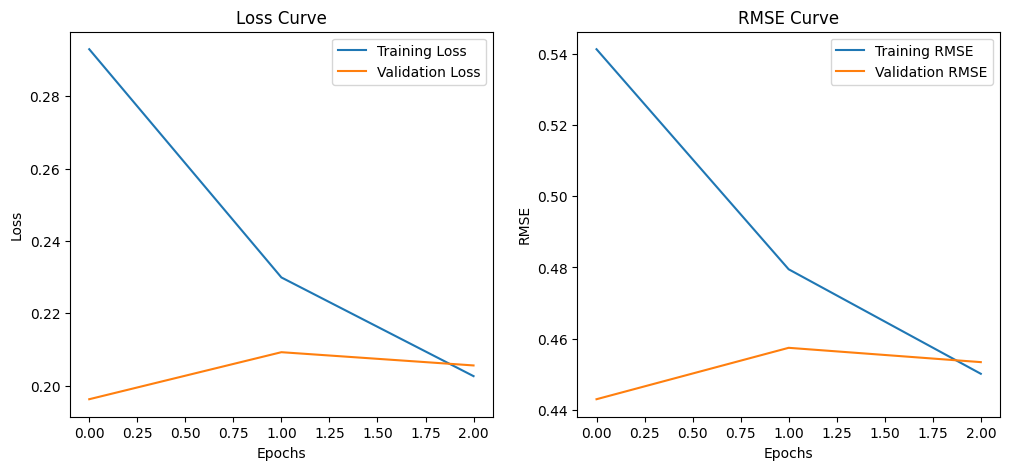

In [44]:
def plot_history(history):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label="Training Loss")
    plt.plot(history['val_loss'], label="Validation Loss")
    plt.title("Loss Curve")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history['train_loss'] ** 0.5, label="Training RMSE")
    plt.plot(history['val_loss'] ** 0.5, label="Validation RMSE")
    plt.title("RMSE Curve")
    plt.xlabel("Epochs")
    plt.ylabel("RMSE")
    plt.legend()

    plt.show()

plot_history(history)

In [45]:
with torch.no_grad():
    model.eval()
    y_pred = model(torch.tensor(X_valid_preprocessed.toarray(), dtype=torch.float32)).cpu().numpy().squeeze()
compute_metrics(valid_target, y_pred)

{'rmse': 0.4533994648255524,
 'r2': 0.2023094892501831,
 'mae': 0.06245399552990871}

# RNN

In [46]:
X_train = X_train.assign(item_cnt_month=train_target)
X_valid = X_valid.assign(item_cnt_month=valid_target)
X_train_valid = pd.concat([X_train, X_valid])

In [47]:
X_train

/Users/miloszhanczyk/Documents/uv/MOW_2/lab/sales_forecasting/.venv/lib/python3.10/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()
/Users/miloszhanczyk/Documents/uv/MOW_2/lab/sales_forecasting/.venv/lib/python3.10/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


,shop_id,item_id,city_id,item_category_id,general_item_category_id,date_month,month_sin,month_cos,lagged_1,lagged_2,...,avg_shop_item_item_price_lag_1,avg_shop_item_item_cnt_day_lag_1,avg_item_item_price_lag_1,avg_item_item_cnt_day_lag_1,avg_shop_item_category_item_price_lag_1,avg_shop_item_category_item_cnt_day_lag_1,avg_item_category_item_price_lag_1,avg_item_category_item_cnt_day_lag_1,months_since_last_buy,item_cnt_month
0,0,0,0,40,11,8,0.866211,-0.500000,0,0,...,169.0,1.0,4488.0,1.000000,270.50,1.163086,264.00,1.080078,0,0
1,0,0,0,40,11,9,0.707031,-0.707031,0,0,...,169.0,1.0,4488.0,1.000000,263.50,1.150391,265.50,1.080078,1,0
2,0,0,0,40,11,10,0.500000,-0.866211,0,0,...,169.0,1.0,4488.0,1.000000,263.75,1.170898,263.75,1.087891,2,0
3,0,0,0,40,11,11,0.258789,-0.965820,0,0,...,169.0,1.0,4488.0,1.000000,262.25,1.138672,264.00,1.089844,3,0
4,0,0,0,40,11,0,0.000000,1.000000,0,0,...,169.0,1.0,4488.0,1.000000,262.50,1.228516,262.00,1.131836,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29460948,59,22169,30,69,14,4,0.866211,0.500000,0,0,...,299.0,1.0,169.0,1.069336,1042.00,1.000000,1093.00,1.047852,14,0
29460949,59,22169,30,69,14,5,0.965820,0.258789,0,0,...,299.0,1.0,169.0,1.069336,489.00,1.000000,1130.00,1.031250,15,0
29460950,59,22169,30,69,14,6,1.000000,0.000000,0,0,...,299.0,1.0,169.0,1.069336,1080.00,1.125000,938.50,1.047852,16,0
29460951,59,22169,30,69,14,7,0.965820,-0.258789,0,0,...,299.0,1.0,169.0,1.069336,553.00,1.151367,738.50,1.071289,17,0


In [48]:
X_valid

/Users/miloszhanczyk/Documents/uv/MOW_2/lab/sales_forecasting/.venv/lib/python3.10/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()
/Users/miloszhanczyk/Documents/uv/MOW_2/lab/sales_forecasting/.venv/lib/python3.10/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


,shop_id,item_id,city_id,item_category_id,general_item_category_id,date_month,month_sin,month_cos,lagged_1,lagged_2,...,avg_shop_item_item_price_lag_1,avg_shop_item_item_cnt_day_lag_1,avg_item_item_price_lag_1,avg_item_item_cnt_day_lag_1,avg_shop_item_category_item_price_lag_1,avg_shop_item_category_item_cnt_day_lag_1,avg_item_category_item_price_lag_1,avg_item_category_item_cnt_day_lag_1,months_since_last_buy,item_cnt_month
13,0,0,0,40,11,9,0.707031,-0.707031,0,0,...,169.0,1.0,4488.0,1.000000,297.00,1.083984,279.500,1.045898,13,0
32,0,1,0,76,15,9,0.707031,-0.707031,0,0,...,169.0,1.0,4488.0,1.000000,297.00,1.083984,1939.000,1.550781,18,0
47,0,2,0,40,11,9,0.707031,-0.707031,0,0,...,169.0,1.0,58.0,1.000000,297.00,1.083984,279.500,1.045898,14,0
63,0,3,0,40,11,9,0.707031,-0.707031,0,0,...,169.0,1.0,100.0,1.000000,297.00,1.083984,279.500,1.045898,15,0
77,0,4,0,40,11,9,0.707031,-0.707031,0,0,...,169.0,1.0,58.0,1.000000,297.00,1.083984,279.500,1.045898,13,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29460846,59,22165,30,31,8,9,0.707031,-0.707031,0,0,...,699.0,1.0,59.0,1.000000,353.25,1.000000,664.500,1.254883,26,0
29460871,59,22166,30,54,12,9,0.707031,-0.707031,0,0,...,699.0,1.0,150.0,1.250000,353.25,1.000000,228.625,1.278320,24,0
29460898,59,22167,30,49,12,9,0.707031,-0.707031,0,0,...,299.0,1.0,299.0,1.049805,334.50,1.000000,469.500,1.098633,15,0
29460933,59,22168,30,62,14,9,0.707031,-0.707031,0,0,...,299.0,1.0,798.5,1.000000,899.00,1.000000,1558.000,1.097656,33,0


In [49]:
X_train_valid

/Users/miloszhanczyk/Documents/uv/MOW_2/lab/sales_forecasting/.venv/lib/python3.10/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()
/Users/miloszhanczyk/Documents/uv/MOW_2/lab/sales_forecasting/.venv/lib/python3.10/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


,shop_id,item_id,city_id,item_category_id,general_item_category_id,date_month,month_sin,month_cos,lagged_1,lagged_2,...,avg_shop_item_item_price_lag_1,avg_shop_item_item_cnt_day_lag_1,avg_item_item_price_lag_1,avg_item_item_cnt_day_lag_1,avg_shop_item_category_item_price_lag_1,avg_shop_item_category_item_cnt_day_lag_1,avg_item_category_item_price_lag_1,avg_item_category_item_cnt_day_lag_1,months_since_last_buy,item_cnt_month
0,0,0,0,40,11,8,0.866211,-0.500000,0,0,...,169.0,1.0,4488.0,1.000000,270.50,1.163086,264.000,1.080078,0,0
1,0,0,0,40,11,9,0.707031,-0.707031,0,0,...,169.0,1.0,4488.0,1.000000,263.50,1.150391,265.500,1.080078,1,0
2,0,0,0,40,11,10,0.500000,-0.866211,0,0,...,169.0,1.0,4488.0,1.000000,263.75,1.170898,263.750,1.087891,2,0
3,0,0,0,40,11,11,0.258789,-0.965820,0,0,...,169.0,1.0,4488.0,1.000000,262.25,1.138672,264.000,1.089844,3,0
4,0,0,0,40,11,0,0.000000,1.000000,0,0,...,169.0,1.0,4488.0,1.000000,262.50,1.228516,262.000,1.131836,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29460846,59,22165,30,31,8,9,0.707031,-0.707031,0,0,...,699.0,1.0,59.0,1.000000,353.25,1.000000,664.500,1.254883,26,0
29460871,59,22166,30,54,12,9,0.707031,-0.707031,0,0,...,699.0,1.0,150.0,1.250000,353.25,1.000000,228.625,1.278320,24,0
29460898,59,22167,30,49,12,9,0.707031,-0.707031,0,0,...,299.0,1.0,299.0,1.049805,334.50,1.000000,469.500,1.098633,15,0
29460933,59,22168,30,62,14,9,0.707031,-0.707031,0,0,...,299.0,1.0,798.5,1.000000,899.00,1.000000,1558.000,1.097656,33,0


In [50]:
def build_vector_tuples(X: pd.DataFrame, save_path: str | None = None):
    embed_cols = ['shop_id', 'item_id', 'city_id', 'item_category_id', 'general_item_category_id']
    embed_entity_index = X[embed_cols].drop_duplicates().reset_index(drop=True)

    seq_cols = np.setdiff1d(X.columns, embed_cols + ['item_cnt_month'])

    vector_tuples = []
    for (shop_id, item_id), group in tqdm(X.groupby(['shop_id', 'item_id'])):
        embed_entities = embed_entity_index[(embed_entity_index.shop_id == shop_id) & (embed_entity_index.item_id == item_id)].values
        seq_matrix = group[seq_cols].values
        target = group['item_cnt_month'].values[-1]
        vector_tuples.append((embed_entities, seq_matrix, target))

    if save_path is not None:
        import pickle
        with open(save_path, 'wb') as f:
            pickle.dump(vector_tuples, f)
    
    return vector_tuples

In [51]:
read = True
if read:
    import pickle
    with open(".data/X_train_vector_tuples.pkl", 'rb') as f:
        X_train_vector_tuples = pickle.load(f)
    with open(".data/X_valid_vector_tuples.pkl", 'rb') as f:
        X_valid_vector_tuples = pickle.load(f)
else:
    X_train_vector_tuples = build_vector_tuples(X_train, save_path=".data/X_train_vector_tuples.pkl")
    X_valid_vector_tuples = build_vector_tuples(X_train_valid, save_path=".data/X_valid_vector_tuples.pkl")

In [52]:
def pad_sequences(matrices):
    L = len(matrices)
    D = matrices[0].shape[1]
    K = max(matrix.shape[0] for matrix in matrices)

    padded_tensor = torch.zeros((L, K, D), dtype=torch.float32)

    for i, matrix in enumerate(matrices):
        n = matrix.shape[0]
        padded_tensor[i, :n, :] = torch.tensor(matrix, dtype=torch.float32)
    return padded_tensor

def pad_sequences1d(sequences):
    L = len(sequences)
    K = max(len(seq) for seq in sequences)

    padded_tensor = torch.zeros((L, K), dtype=torch.float32)

    for i, seq in enumerate(sequences):
        n = len(seq)
        padded_tensor[i, :n] = torch.tensor(seq, dtype=torch.float32)
    return padded_tensor

In [53]:
class SalesDataset(Dataset):
    def __init__(self, df_tuples_array: list[tuple[np.ndarray, np.ndarray, np.ndarray]]):
        self.df = df_tuples_array
        self.embed_entities = torch.tensor([x[0] for x in self.df], dtype=torch.long).squeeze(1)
        self.seq_matr = pad_sequences([torch.tensor(x[1], dtype=torch.float32) for x in self.df])
        
        self.targets = torch.tensor([x[2] for x in self.df], dtype=torch.float32).unsqueeze(1)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        return (self.embed_entities[idx], 
                self.seq_matr[idx],
                self.targets[idx])


In [54]:
class SalesPredictionModel(nn.Module):
    def __init__(self, emb_cardinality, embedding_size, dropout_rate, seq_input_size):
        super(SalesPredictionModel, self).__init__()
        
        # Embedding layers for categorical variables
        self._embedding_size = embedding_size
        self._emb_cardinality = emb_cardinality
        self.embeddings = nn.ModuleList([
            nn.Embedding(num_embeddings, self._embedding_size) 
            for num_embeddings in self._emb_cardinality
        ])
        self._emb_dim_sum = len(self._emb_cardinality) * self._embedding_size

        # LSTM layer
        self._lstm_input_size = seq_input_size
        self._lstm_hidden_size = 2 * embedding_size
        self.lstm = nn.LSTM(
            input_size=self._lstm_input_size,
            hidden_size=self._lstm_hidden_size,
            batch_first=True
        )
        
        # Fully connected layer
        self._fc_input_size = self._lstm_hidden_size + self._emb_dim_sum
        self.fc = nn.Linear(self._fc_input_size, 1)

        # Dropout layer
        self.dropout = nn.Dropout(0.1)

    def forward(self, embed, seq):
        # Embedding layers
        embedded_features = [embedding(embed[:, i]) for i, embedding in enumerate(self.embeddings)]
        emb_tensors = torch.cat(embedded_features, dim=1)
        #emb_tensors = self.dropout(emb_tensors) 

        # LSTM
        _, (lstm_hidden_state, _) = self.lstm(seq)
        lstm_hidden_state = lstm_hidden_state[-1]

        # Concatenate embeddings and LSTM output
        concatenated = torch.cat([emb_tensors, lstm_hidden_state], dim=1)

        output = self.fc(concatenated)

        return output

In [55]:
batch_size = 4096

train_dataset = SalesDataset(X_train_vector_tuples)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = SalesDataset(X_valid_vector_tuples)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


/var/folders/nn/v5bcwy852z121w7pz8m7sypr0000gn/T/ipykernel_82532/2401640554.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:281.)
  self.embed_entities = torch.tensor([x[0] for x in self.df], dtype=torch.long).squeeze(1)
/var/folders/nn/v5bcwy852z121w7pz8m7sypr0000gn/T/ipykernel_82532/1370659372.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_tensor[i, :n, :] = torch.tensor(matrix, dtype=torch.float32)


In [56]:
# Parameters
emb_cardinality = X_train.shop_id.max()+1, X_train.item_id.max()+1, X_train.city_id.max()+1, X_train.item_category_id.max()+1, X_train.general_item_category_id.max()+1
embedding_size = 16
dropout_rate = 0.3
seq_input_size = 26
lr = 1e-4
device = torch.device("cpu")

model = SalesPredictionModel(emb_cardinality, embedding_size, dropout_rate, seq_input_size).to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)


In [57]:
model

SalesPredictionModel(
  (embeddings): ModuleList(
    (0): Embedding(60, 16)
    (1): Embedding(22170, 16)
    (2): Embedding(31, 16)
    (3): Embedding(84, 16)
    (4): Embedding(20, 16)
  )
  (lstm): LSTM(26, 32, batch_first=True)
  (fc): Linear(in_features=112, out_features=1, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
)

In [58]:
def train(
    model: nn.Module, 
    loss_fn: Callable,
    optimizer: torch.optim.Optimizer,
    train_loader: DataLoader,
    device: torch.device, 
    epoch: int, 
    print_every: None | int = None
) -> float:
    model.train()
    train_loss = 0.

    for batch_idx, batch in enumerate(train_loader):
        embed, seq, target = (_.to(device) for _ in batch)
        
        optimizer.zero_grad()
        output = model(embed, seq)
        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()

        loss_item = loss.detach().cpu().item()

        if print_every is not None and batch_idx % print_every == 0:
            print(
                "Train (Batch): [{}/{} ({:.0f}%)]\tTrain Loss: {:.4f} \tTrain RMSE: {:.4f}".format(
                    batch_idx, len(train_loader), 100.0 * batch_idx / len(train_loader), loss_item, loss_item ** 0.5
                ) # type: ignore
            )
        train_loss += loss_item

    train_loss /= len(train_loader)

    return train_loss


def test(
    model: nn.Module, 
    loss_fn: Callable,
    device: torch.device,
    test_loader: DataLoader, 
    print_every: None | int = None
) -> float:
    model.eval()
    test_loss = 0.
    with torch.no_grad():
        for batch_idx, batch in enumerate(test_loader):
            embed, seq, target = (_.to(device) for _ in batch)
            output = model(embed, seq)
            loss =  loss_fn(output, target)

            loss_item = loss.detach().cpu().item()
            test_loss += loss_item

    test_loss /= len(test_loader)

    if print_every is not None:
        print(
            "\nTest: Test loss: {:.4f} \t Test RMSE: {:.4f}\n".format(test_loss, test_loss ** 0.5) # type: ignore
        )
    
    return test_loss

In [59]:
history = {
    'train_loss': [],
    'val_loss': []
}

EPOCHS = 15
for epoch in tqdm(range(1, EPOCHS + 1)):
    history['train_loss'].append(train(model, criterion, optimizer, train_loader, device, epoch, print_every=100))
    history['val_loss'].append(test(model, criterion, device, val_loader, print_every=1))

history['train_loss'] = np.array(history['train_loss'])
history['val_loss'] = np.array(history['val_loss'])

history['train_rmse'] = history['train_loss'] ** 0.5
history['val_rmse'] = history['val_loss'] ** 0.5

  0%|          | 0/15 [00:00<?, ?it/s]

Train (Batch): [0/292 (0%)]	Train Loss: 0.4608 	Train RMSE: 0.6788
Train (Batch): [100/292 (34%)]	Train Loss: 0.4934 	Train RMSE: 0.7024
Train (Batch): [200/292 (68%)]	Train Loss: 0.4921 	Train RMSE: 0.7015


  7%|▋         | 1/15 [00:37<08:44, 37.47s/it]


Test: Test loss: 0.3397 	 Test RMSE: 0.5828

Train (Batch): [0/292 (0%)]	Train Loss: 0.3544 	Train RMSE: 0.5953
Train (Batch): [100/292 (34%)]	Train Loss: 0.5914 	Train RMSE: 0.7690
Train (Batch): [200/292 (68%)]	Train Loss: 0.2514 	Train RMSE: 0.5014


 13%|█▎        | 2/15 [01:15<08:11, 37.80s/it]


Test: Test loss: 0.2800 	 Test RMSE: 0.5291

Train (Batch): [0/292 (0%)]	Train Loss: 0.1445 	Train RMSE: 0.3801
Train (Batch): [100/292 (34%)]	Train Loss: 0.1616 	Train RMSE: 0.4020
Train (Batch): [200/292 (68%)]	Train Loss: 0.2402 	Train RMSE: 0.4901


 20%|██        | 3/15 [01:55<07:45, 38.79s/it]


Test: Test loss: 0.2607 	 Test RMSE: 0.5106

Train (Batch): [0/292 (0%)]	Train Loss: 0.2500 	Train RMSE: 0.5000
Train (Batch): [100/292 (34%)]	Train Loss: 0.2172 	Train RMSE: 0.4660
Train (Batch): [200/292 (68%)]	Train Loss: 0.1193 	Train RMSE: 0.3454


 27%|██▋       | 4/15 [02:33<07:02, 38.38s/it]


Test: Test loss: 0.2536 	 Test RMSE: 0.5036

Train (Batch): [0/292 (0%)]	Train Loss: 0.1869 	Train RMSE: 0.4323
Train (Batch): [100/292 (34%)]	Train Loss: 0.2098 	Train RMSE: 0.4581
Train (Batch): [200/292 (68%)]	Train Loss: 0.1230 	Train RMSE: 0.3507


 33%|███▎      | 5/15 [03:10<06:20, 38.05s/it]


Test: Test loss: 0.2495 	 Test RMSE: 0.4995

Train (Batch): [0/292 (0%)]	Train Loss: 0.2229 	Train RMSE: 0.4721
Train (Batch): [100/292 (34%)]	Train Loss: 0.1256 	Train RMSE: 0.3544
Train (Batch): [200/292 (68%)]	Train Loss: 0.2757 	Train RMSE: 0.5250


 40%|████      | 6/15 [03:48<05:41, 37.91s/it]


Test: Test loss: 0.2490 	 Test RMSE: 0.4990

Train (Batch): [0/292 (0%)]	Train Loss: 0.4553 	Train RMSE: 0.6747
Train (Batch): [100/292 (34%)]	Train Loss: 0.3091 	Train RMSE: 0.5559
Train (Batch): [200/292 (68%)]	Train Loss: 0.1493 	Train RMSE: 0.3864


 47%|████▋     | 7/15 [04:25<05:02, 37.81s/it]


Test: Test loss: 0.2450 	 Test RMSE: 0.4950

Train (Batch): [0/292 (0%)]	Train Loss: 0.4033 	Train RMSE: 0.6351
Train (Batch): [100/292 (34%)]	Train Loss: 0.1933 	Train RMSE: 0.4396
Train (Batch): [200/292 (68%)]	Train Loss: 0.2584 	Train RMSE: 0.5083


 53%|█████▎    | 8/15 [05:03<04:24, 37.74s/it]


Test: Test loss: 0.2439 	 Test RMSE: 0.4939

Train (Batch): [0/292 (0%)]	Train Loss: 0.1129 	Train RMSE: 0.3360
Train (Batch): [100/292 (34%)]	Train Loss: 0.3278 	Train RMSE: 0.5725
Train (Batch): [200/292 (68%)]	Train Loss: 0.1311 	Train RMSE: 0.3621


 60%|██████    | 9/15 [05:41<03:46, 37.73s/it]


Test: Test loss: 0.2396 	 Test RMSE: 0.4895

Train (Batch): [0/292 (0%)]	Train Loss: 0.1664 	Train RMSE: 0.4080
Train (Batch): [100/292 (34%)]	Train Loss: 0.1382 	Train RMSE: 0.3718
Train (Batch): [200/292 (68%)]	Train Loss: 0.2254 	Train RMSE: 0.4748


 67%|██████▋   | 10/15 [06:18<03:08, 37.68s/it]


Test: Test loss: 0.2413 	 Test RMSE: 0.4912

Train (Batch): [0/292 (0%)]	Train Loss: 0.4150 	Train RMSE: 0.6442
Train (Batch): [100/292 (34%)]	Train Loss: 0.1816 	Train RMSE: 0.4262
Train (Batch): [200/292 (68%)]	Train Loss: 0.0959 	Train RMSE: 0.3097


 73%|███████▎  | 11/15 [06:56<02:30, 37.68s/it]


Test: Test loss: 0.2429 	 Test RMSE: 0.4928

Train (Batch): [0/292 (0%)]	Train Loss: 0.1647 	Train RMSE: 0.4058
Train (Batch): [100/292 (34%)]	Train Loss: 0.1593 	Train RMSE: 0.3992
Train (Batch): [200/292 (68%)]	Train Loss: 0.3061 	Train RMSE: 0.5533


 80%|████████  | 12/15 [07:34<01:52, 37.65s/it]


Test: Test loss: 0.2405 	 Test RMSE: 0.4904

Train (Batch): [0/292 (0%)]	Train Loss: 0.1018 	Train RMSE: 0.3191
Train (Batch): [100/292 (34%)]	Train Loss: 0.1398 	Train RMSE: 0.3739
Train (Batch): [200/292 (68%)]	Train Loss: 0.1756 	Train RMSE: 0.4191


 87%|████████▋ | 13/15 [08:11<01:15, 37.71s/it]


Test: Test loss: 0.2382 	 Test RMSE: 0.4880

Train (Batch): [0/292 (0%)]	Train Loss: 0.2346 	Train RMSE: 0.4843
Train (Batch): [100/292 (34%)]	Train Loss: 0.1751 	Train RMSE: 0.4184
Train (Batch): [200/292 (68%)]	Train Loss: 0.0760 	Train RMSE: 0.2757


 93%|█████████▎| 14/15 [08:49<00:37, 37.67s/it]


Test: Test loss: 0.2353 	 Test RMSE: 0.4851

Train (Batch): [0/292 (0%)]	Train Loss: 0.3364 	Train RMSE: 0.5800
Train (Batch): [100/292 (34%)]	Train Loss: 0.1377 	Train RMSE: 0.3711
Train (Batch): [200/292 (68%)]	Train Loss: 0.3152 	Train RMSE: 0.5614


100%|██████████| 15/15 [09:27<00:00, 37.85s/it]


Test: Test loss: 0.2350 	 Test RMSE: 0.4848



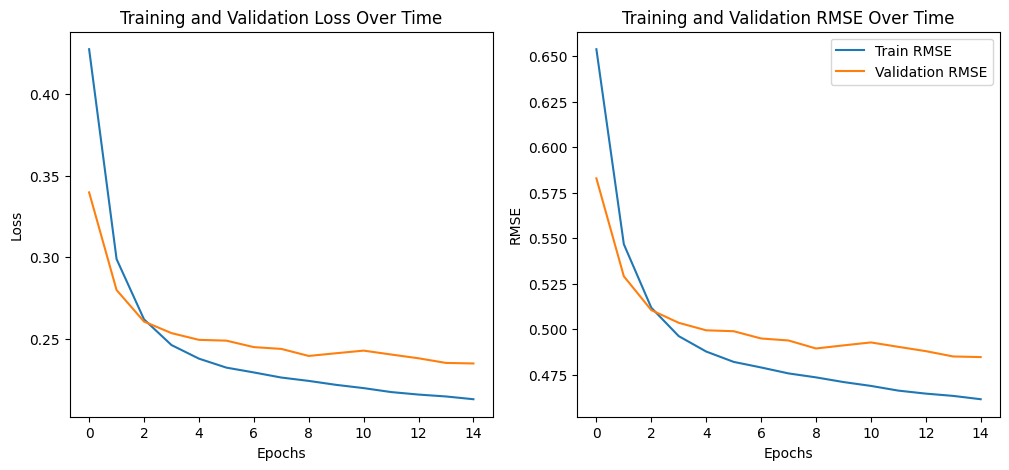

In [60]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].plot(history['train_loss'], label='Train Loss')
ax[0].plot(history['val_loss'], label='Validation Loss')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_title('Training and Validation Loss Over Time')

ax[1].plot(history['train_rmse'], label='Train RMSE')
ax[1].plot(history['val_rmse'], label='Validation RMSE')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('RMSE')
ax[1].set_title('Training and Validation RMSE Over Time')

plt.legend()
plt.show()

In [61]:
valid_targets = torch.cat([i[2] for i in val_dataset]).numpy()
with torch.no_grad():
    model.eval()
    y_pred = []
    for batch_idx, batch in enumerate(val_loader):
        embed, seq, target = (_.to(device) for _ in batch)
        output = model(embed, seq)
        y_pred.append(output.cpu().numpy())

compute_metrics(valid_targets, np.concatenate(y_pred))

{'rmse': 0.48482567071914673,
 'r2': 0.0878974199295044,
 'mae': 0.12028618156909943}